In [1]:
# Initial imports

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchsummary import summary #https://github.com/sksq96/pytorch-summary
torch.manual_seed(1234)
np.random.seed(1234)
from torch.utils.data import Subset

from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

import matplotlib
font = {'size'   : 16}

matplotlib.rc('font', **font)

# Now let's get the real-world data and try to interpret it

#### What are we conceptually trying to do here? 

#### What are some of the pluses and minuses of this approach?

#### How else could we do this? (Also leave for the later discussion)

### Load the HINODE quiet Sun data and visualize it

In [9]:
obs_stokes = fits.open("/home/milic/data/hinode/lites_qs.fits")[0].data

In [10]:
obs_stokes.shape

(1024, 2047, 4, 112)

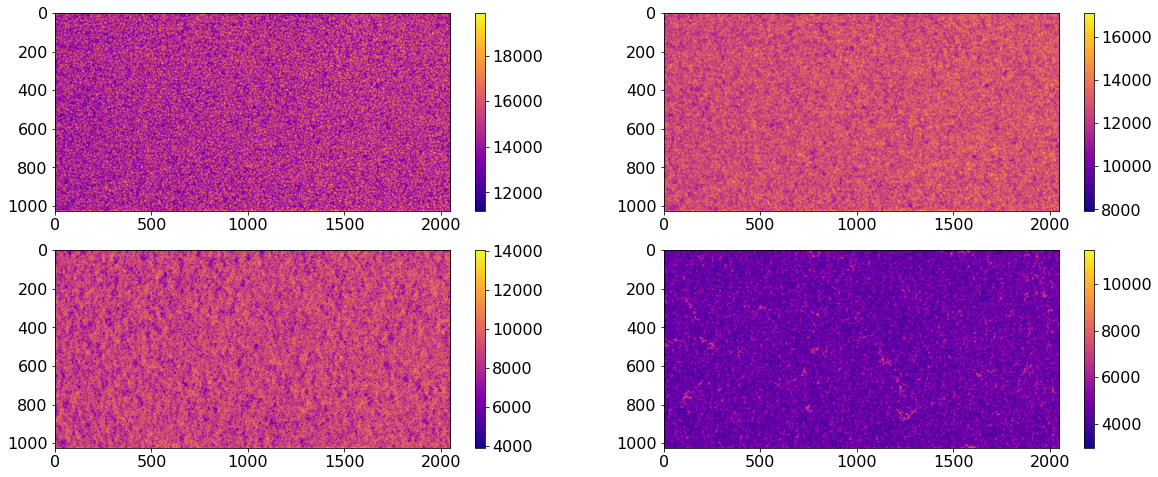

In [17]:
plt.figure(figsize=[20,8])
plt.subplot(221)
plt.imshow(obs_stokes[:,:,0,10],cmap='plasma')
plt.colorbar()
plt.subplot(222)
plt.imshow(obs_stokes[:,:,0,23],cmap='plasma')
plt.colorbar()
plt.subplot(223)
plt.imshow(obs_stokes[:,:,0,26],cmap='plasma')
plt.colorbar()
plt.subplot(224)
plt.imshow(obs_stokes[:,:,0,29],cmap='plasma')
plt.colorbar()

### At the first look, it seems different, that is because this field of view is much larger, let's cut out roughly one - tenth of the field of view

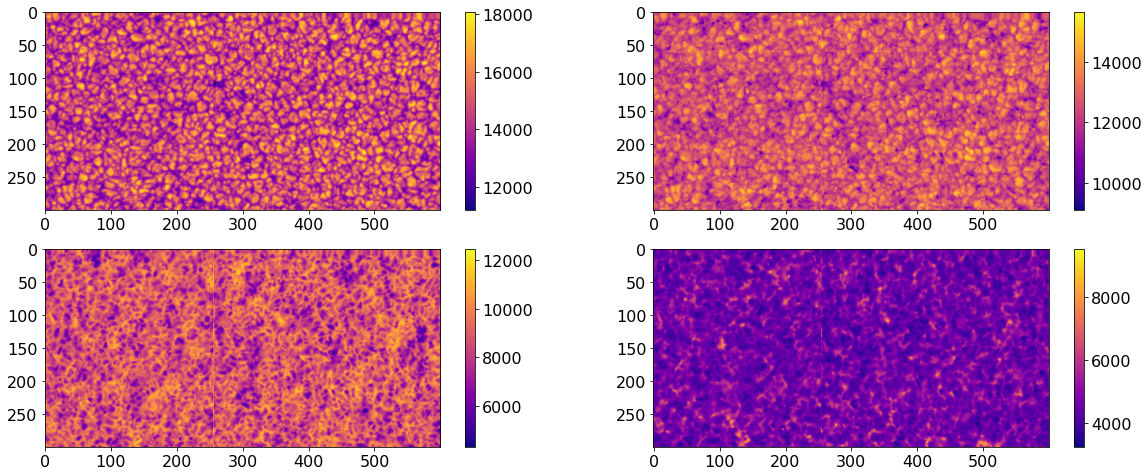

In [18]:
plt.figure(figsize=[20,8])
plt.subplot(221)
plt.imshow(obs_stokes[:300,:600,0,10],cmap='plasma')
plt.colorbar()
plt.subplot(222)
plt.imshow(obs_stokes[:300,:600,0,23],cmap='plasma')
plt.colorbar()
plt.subplot(223)
plt.imshow(obs_stokes[:300,:600,0,26],cmap='plasma')
plt.colorbar()
plt.subplot(224)
plt.imshow(obs_stokes[:300,:600,0,29],cmap='plasma')
plt.colorbar()

## A bit more familiar right?

#### Now note that the magnitude of the identity

#### Our training data and the data to apply are not in the same units. We need some sort of the conversion...

#### For the moment, I will normalize it in the exactly same way as we did with the training data (different constants of course). Why is this (kinda) ok? When would it not be?

In [20]:
to_fit = np.copy(obs_stokes[:,:,0,:])
to_fit_max = np.amax(to_fit)
to_fit_min = np.amin(to_fit)

In [21]:
to_fit = to_fit.reshape(-1,112)

In [46]:
to_fit = (to_fit - to_fit_min) / (to_fit_max - to_fit_min)

In [47]:
to_fit = torch.from_numpy(to_fit.astype("float32"))

AttributeError: 'Tensor' object has no attribute 'astype'

In [48]:
# This is faily simple fully connected, not-so-deep neural network:

# Discuss in moderate detail what each thing does: 


class dnn(nn.Module):
    def __init__(self, inputsize, outputsize):
        super(dnn, self).__init__()
        self.linear1 = nn.Linear(inputsize,64)
        self.linear1a = nn.Linear(64,64)
        self.linear2 = nn.Linear(64,32)
        self.linear2a = nn.Linear(32,32)
        self.linear3 = nn.Linear(32,24)
        self.linear4 = nn.Linear(24,24)
        self.linear5 = nn.Linear(24,24)
        self.linear6 = nn.Linear(24,outputsize)
        
        
        self.activation = nn.ReLU()
        self.activationS = nn.Sigmoid()
        
        
        self.dropout05 = nn.Dropout(0.5)
        
        
    def forward(self, data_in):
        
        x = self.linear1(data_in)
        x = self.activationS(x)
        x = self.linear1a(x)
        x = self.activationS(x)
        x = self.linear2(x)
        x = self.activationS(x)
        x = self.linear2a(x)
        x = self.activationS(x)
        x = self.linear3(x)
        x = self.activationS(x)
        x = self.linear4(x)
        x = self.activationS(x)
        x = self.linear5(x)
        x = self.activationS(x)
        data_out = self.linear6(x)
            
        return data_out
    
def make_model(cudaoption, inputsize, outputsize):
    
    model = dnn(inputsize, outputsize)
    
    if (cudaoption):
        print('[INFO] Cuda model:',torch.cuda.get_device_name(0))
        model = model.to(device)
        
        print('[INFO] Parameters in GPU:',next(model.parameters()).is_cuda) 
        
    return model   

def model_predict(model, inputdata, cudaoption):
    
    if cudaoption:
        
        model = model.to(device)
        inputdata = inputdata.to(device)
        
    output = model.forward(inputdata)
    
    output = output.to("cpu")
    return output

## Let's make a function to train:

def compilefit(model, data_in, data_out, data_val_in, data_val_out, nepochs, criterion, cudaoption, lri, output_interval, batch, weight_decayi):
    
    optimizer = torch.optim.Adam(model.parameters(), lr = lri, weight_decay = weight_decayi)
    loss_fn = nn.MSELoss()
    loss_val_fn = nn.MSELoss()
    
    if cudaoption:
        data_in = data_in.to(device)
        data_out = data_out.to(device)
        data_val_in = data_val_in.to(device)
        data_val_out = data_val_out.to(device)
        
        
    performance = np.zeros([2,nepochs])
                
    for i in range(0,nepochs):
            
        optimizer.zero_grad()
        out = model.forward(data_in)
        loss = loss_fn(data_out, out)
        loss.backward()
        optimizer.step()
        performance[0,i] = loss.item()
        
        # Validation:
        out_val = model.forward(data_val_in)
        loss_val = loss_val_fn(out_val, data_val_out)
        performance[1,i] = loss_val.item()
        
            
        if (i+1)%int(output_interval)==0: print(f' It : {i+1:3d} - residual std : {np.sqrt(loss.item()):.6f} - val std : {np.sqrt(loss_val.item()):.6f}')
    return performance

In [49]:
cudaoption = torch.cuda.is_available()
device = torch.device("cuda:0" if cudaoption else "cpu")
print('[INFO] Cuda:', cudaoption)
print('[INFO] Cuda device:', device)

[INFO] Cuda: False
[INFO] Cuda device: cpu


In [50]:
dnn_model = torch.load("inv_full_take_1.pt",map_location=torch.device('cpu'))

In [51]:
test_output = model_predict(dnn_model,to_fit,cudaoption)

In [52]:
test_output = test_output.detach().numpy()

In [53]:
test_output.shape

(2096128, 8)

In [54]:
test_output = test_output.reshape(1024,2047,-1)

In [55]:
test_output.shape

(1024, 2047, 8)

In [56]:
T_min,T_max = fits.open("normalized_data_out.fits")[2].data
vz_min,vz_max = fits.open("normalized_data_out.fits")[3].data

In [57]:
print (T_min, T_max)
print (vz_min, vz_max)

3531.2879657992307 9197.149906312086
-10.194147996052461 15.062315705935136


In [58]:
# Looks good, now let's return our results to physical units

In [59]:
T_output = test_output[:,:,:4] * (T_max - T_min) + T_min

In [60]:
vz_output = test_output[:,:,4:] * (vz_max - vz_min) + vz_min

### Exciting, let's plot:

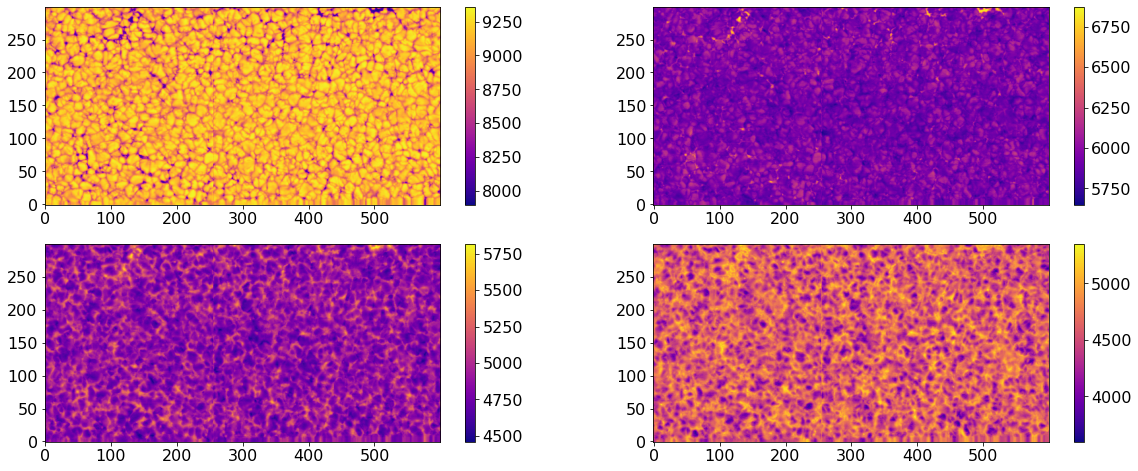

In [63]:
plt.figure(figsize=[20,8])
plt.subplot(221)
plt.imshow(T_output[:300,:600,0],cmap='plasma',origin='lower')
plt.colorbar()
plt.subplot(222)
plt.imshow(T_output[:300,:600,1],cmap='plasma',origin='lower')
plt.colorbar()
plt.subplot(223)
plt.imshow(T_output[:300,:600,2],cmap='plasma', origin='lower')
plt.colorbar()
plt.subplot(224)
plt.imshow(T_output[:300,:600,3],cmap='plasma', origin='lower')
plt.colorbar()

### The results look good at the first glance, but they are a little weird. Any ideas how we can make this better?

### Also why am I saying they are a little weird? 

### Before that, have a look at the velocities...

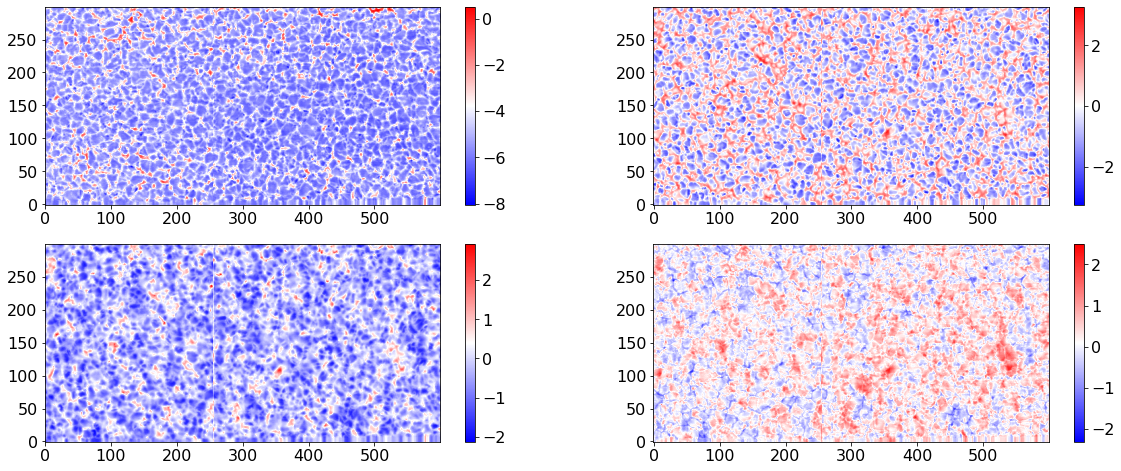

In [67]:
plt.figure(figsize=[20,8])
plt.subplot(221)
plt.imshow(vz_output[:300,:600,0],cmap='bwr',origin='lower')
plt.colorbar()
plt.subplot(222)
plt.imshow(vz_output[:300,:600,1],cmap='bwr',origin='lower')
plt.colorbar()
plt.subplot(223)
plt.imshow(vz_output[:300,:600,2],cmap='bwr', origin='lower')
plt.colorbar()
plt.subplot(224)
plt.imshow(vz_output[:300,:600,3],cmap='bwr', origin='lower')
plt.colorbar()

## Now, let's set aside some time for a lengthy discussion on if and why our results make sense